# Visualization of VIT classification

In this notebook, we show-case how to:
* use the pre-trained models that we provide to make classifications
* visualize the attentions of the model to gain insights on the way it sees the images.

## Preliminaries
This section contains the boilerplate necessary for the other sections. Run it first.

In [10]:
%load_ext autoreload

import sys
#sys.path.insert(0, "../..")

import os
#os.chdir("../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

Declare all the params here now....

In [12]:
dataset = 'cifar10'
image_size= 224
num_heads= 12
num_layers= 12
num_classes= 10 if dataset=='cifar10' else 30
ckpt = '/nfs/data3/koner/contrastive_ood/save/vit/vit_224SupCE_cifar10_bs512_lr0.01_wd1e-05_temp_0.1_210316_122535/checkpoints/ckpt_epoch_50.pth'

In [13]:
# cifar10 classes
cifar10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Imagenet30 classes
im30_CLASSES = ['acorn', 'airliner', 'ambulance', 'american_alligator', 'banjo', 'barn', 'bikini', 'digital_clock',
                'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand_piano', 'hotdog', 'hourglass', 'manhole_cover', 'mosque', 'nail',
                'parking_meter', 'pillow', 'revolver', 'rotary_dial_telephone', 'schooner', 'snowmobile', 'soccer_ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano']
# select the dataset either cfar10 or Imagenet30
CLASSES = cifar10_CLASSES
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
print('Number of classes : ',CLASSES)

Number of classes :  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [14]:
# standard PyTorch mean-std input image normalization
from torchvision.transforms import transforms as T
transform = T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])
# just resize the image for visualization
resize_transform = T.Compose([
            T.Resize((224,224))])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [15]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Detection - using a pre-trained model from TorchHub

In this section, we show-case how to load a model from existing checkpoint, run it on a custom image, and print the result.
Here we load the simplest of vit-160) for fast inference.

In [16]:
from vit.src.model import VisionTransformer as ViT
# load ckpt
ckpt = torch.load(ckpt, map_location=torch.device("cpu"))
model = ViT(image_size=(image_size,image_size),
             num_heads=num_heads,
             num_layers=num_layers,
             num_classes=num_classes,
             contrastive=False,
             timm=True)
# now load the model
model.load_state_dict(ckpt['state_dict'], strict=False)
model = model.to(device="cpu")#cuda()
model.eval();
print('Model loaded....')

Model loaded....


We now retrieve the image as a PIL image

In [125]:
import numpy as np
#img_path = '/nfs/data3/koner/contrastive_ood/data/ImageNet30/val/airliner/15.JPEG'
#img_path = '/nfs/data3/koner/contrastive_ood/data/ImageNet30/val/barn/12.JPEG'
#img_path = '/nfs/data3/koner/contrastive_ood/data/ImageNet30/val/volcano/n09472597/30.JPEG'
#img_path = '/nfs/data3/koner/contrastive_ood/data/ImageNet30/val/american_alligator/5.JPEG'
img_path = '/home/koner/contrastive_ood/data/cifar10png/test/truck/0071.jpg'
#img_path = '/home/koner/contrastive_ood/data/cifar10png/test/ship/0090.jpg'
#img_path = '/home/koner/contrastive_ood/data/cifar100png/test/vehicles_1/pickup_truck/0004.png'
split_text = img_path.split('/')
img_name = split_text[-2]+'_'+split_text[-1].split('.')[0] 

print('Opening Image from : ', img_path)
im = Image.open(img_path)

Opening Image from :  /home/koner/contrastive_ood/data/cifar10png/test/truck/0071.jpg


In [126]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im)
img = img.unsqueeze(0).to(device="cpu")#.cuda()
print('Shape of the image : ',img.shape)
# propagate through the model
outputs, softmax_prediction = model(img, feat_cls=True)
print('Shape of output : ',outputs.shape)
softmax_score = F.softmax(softmax_prediction).data.cpu().numpy()
softmax_score = np.around(softmax_score[0],4)
softmaxt_sort_ind = np.argsort(softmax_score)[::-1]
print("Predicted class : ",np.asarray(CLASSES)[softmaxt_sort_ind])
softmaxt_sort_score  = np.sort(softmax_score)[::-1]
print("Srt Score : ",softmaxt_sort_score)
#print('Softmax prediction : ', F.softmax(softmax_prediction).data.cpu())

Shape of the image :  torch.Size([1, 3, 224, 224])
Shape of output :  torch.Size([1, 768])
Predicted class :  ['truck' 'ship' 'horse' 'frog' 'dog' 'deer' 'cat' 'bird' 'automobile'
 'airplane']
Srt Score :  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/koner/anaconda3/envs/torch1.6/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


# Detection - Visualize encoder-decoder multi-head attention weights
Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.

We will use hooks to extract attention weights (averaged over all heads) from the transformer.

In [127]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, cls_token_attn = [], [], []

# def get_attension_vit(self, input, output):
#     enc_attn_weights.append(self.scores)

hooks = [ 
    model.transformer.encoder_layers[-2].attn.register_forward_hook(
        lambda self, input, output:conv_features.append(output)
    ),]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# enc_attn_weights.append(model.backbone.transformer.blocks[-1].attn.scores)
    
# don't need the list anymore
conv_features = conv_features[0]



In [128]:
for i in range(12):
    cls_token_attn.append(torch.squeeze(model.transformer.encoder_layers[i].attn.score)[:,0,1:])
    enc_attn_weights.append(torch.squeeze(model.transformer.encoder_layers[i].attn.score)[:,1:,1:])

Now let's visualize them

In [145]:
# output of the CNN
print("Encoder attention:      ",enc_attn_weights[0].shape)
f_map = (14,14)
print("Feature map:            ", f_map)
head_to_show = 8 # change head number based on which attention u want to see
print('Showing head : {}'.format(head_to_show))
#wo_cls_enc_attn_score = enc_attn_weights[:,1:,1:]
#print("Shape of the Encoder attention w/o cls map ",wo_cls_enc_attn_score.shape)

Encoder attention:       torch.Size([12, 196, 196])
Feature map:             (14, 14)
Showing head : 8


# Visualize encoder self-attention weights

In this section we visualize the model's self-attention. This allows us to gain intuition on how the model encodes the objects. In particular, we see from the attention response maps that the encoder already participate to the instance separation process.

Let's start by visualizing the shape of the encoder self-attention:

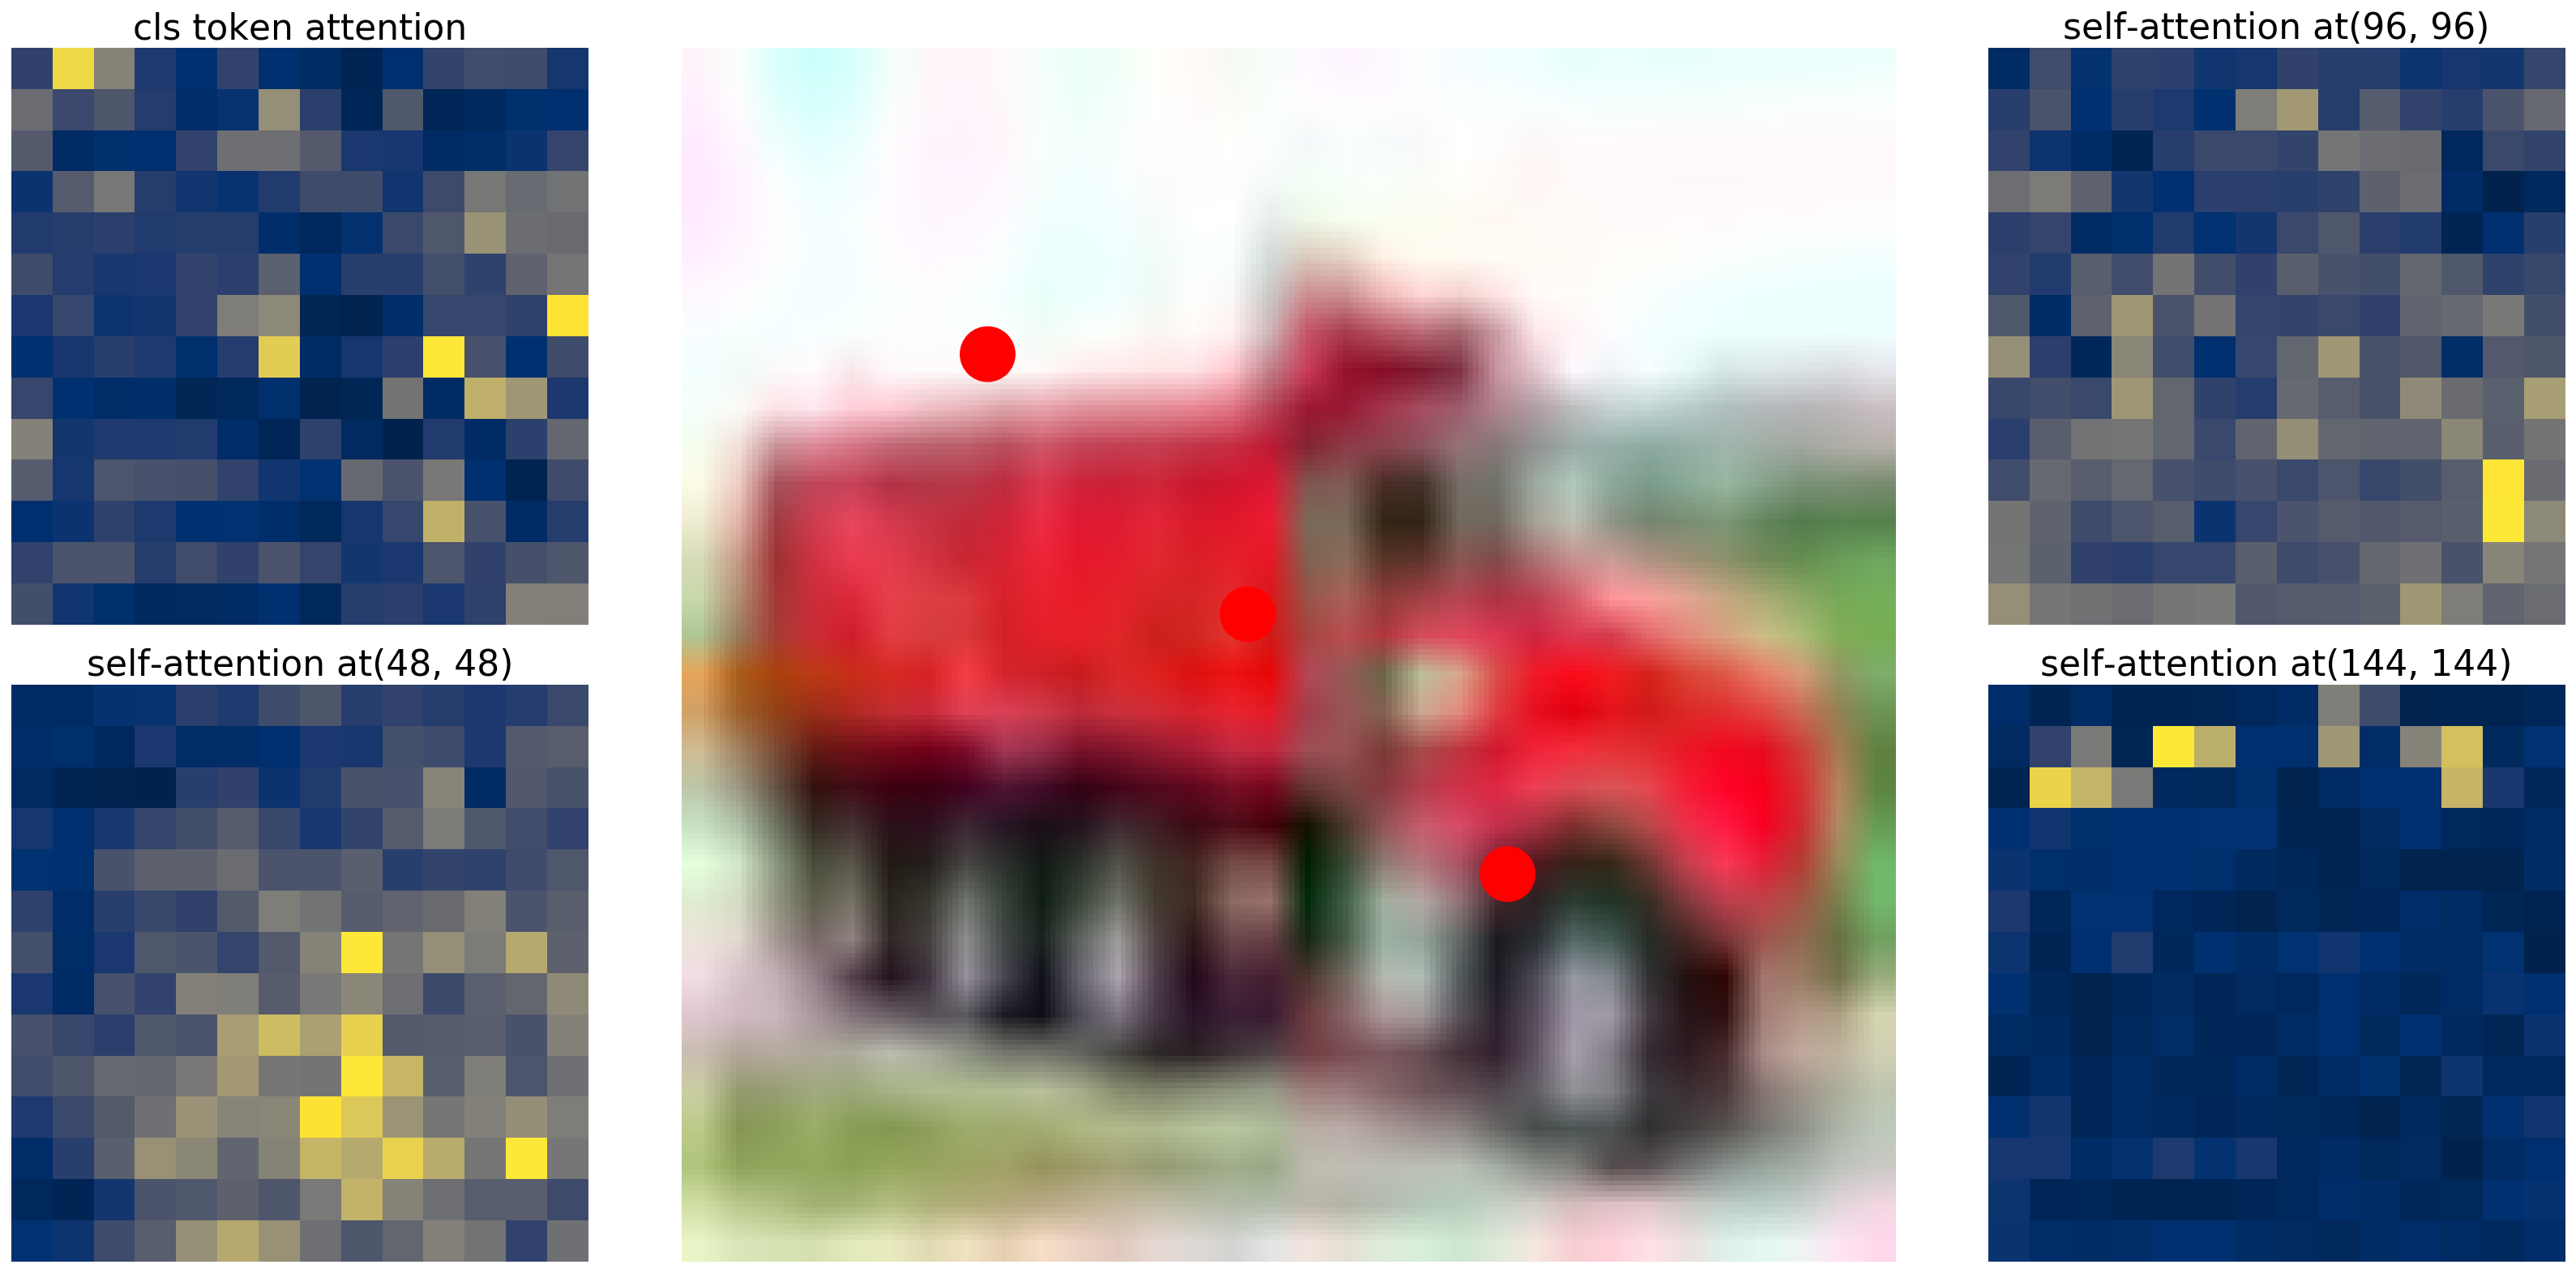

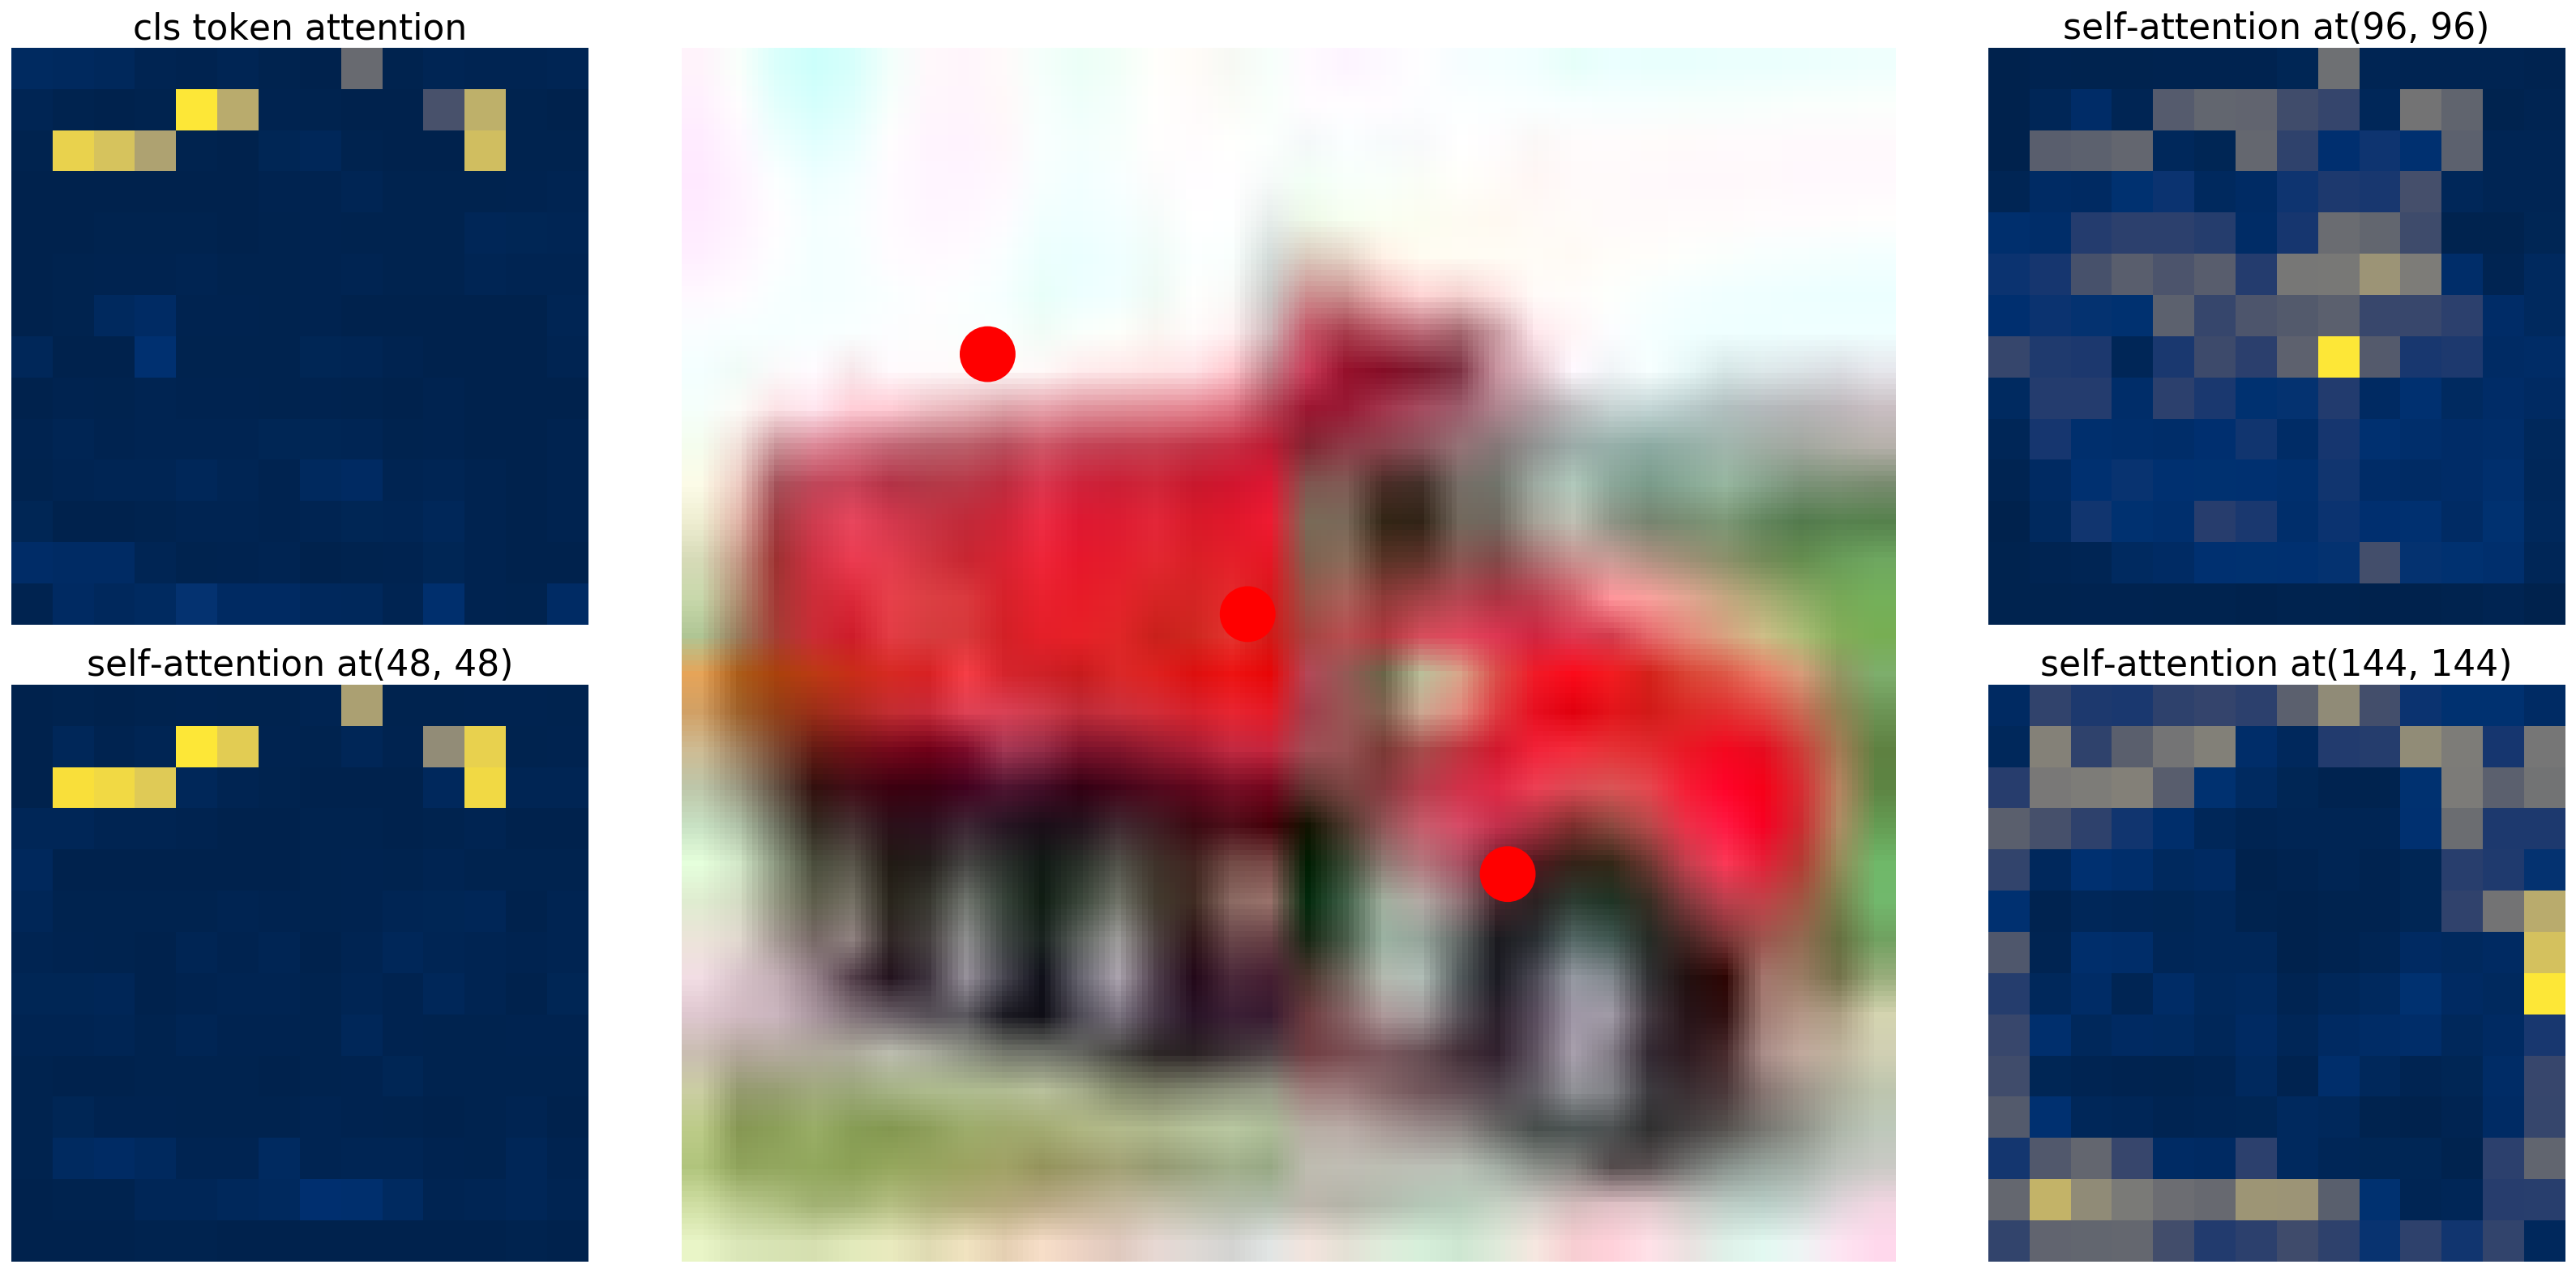

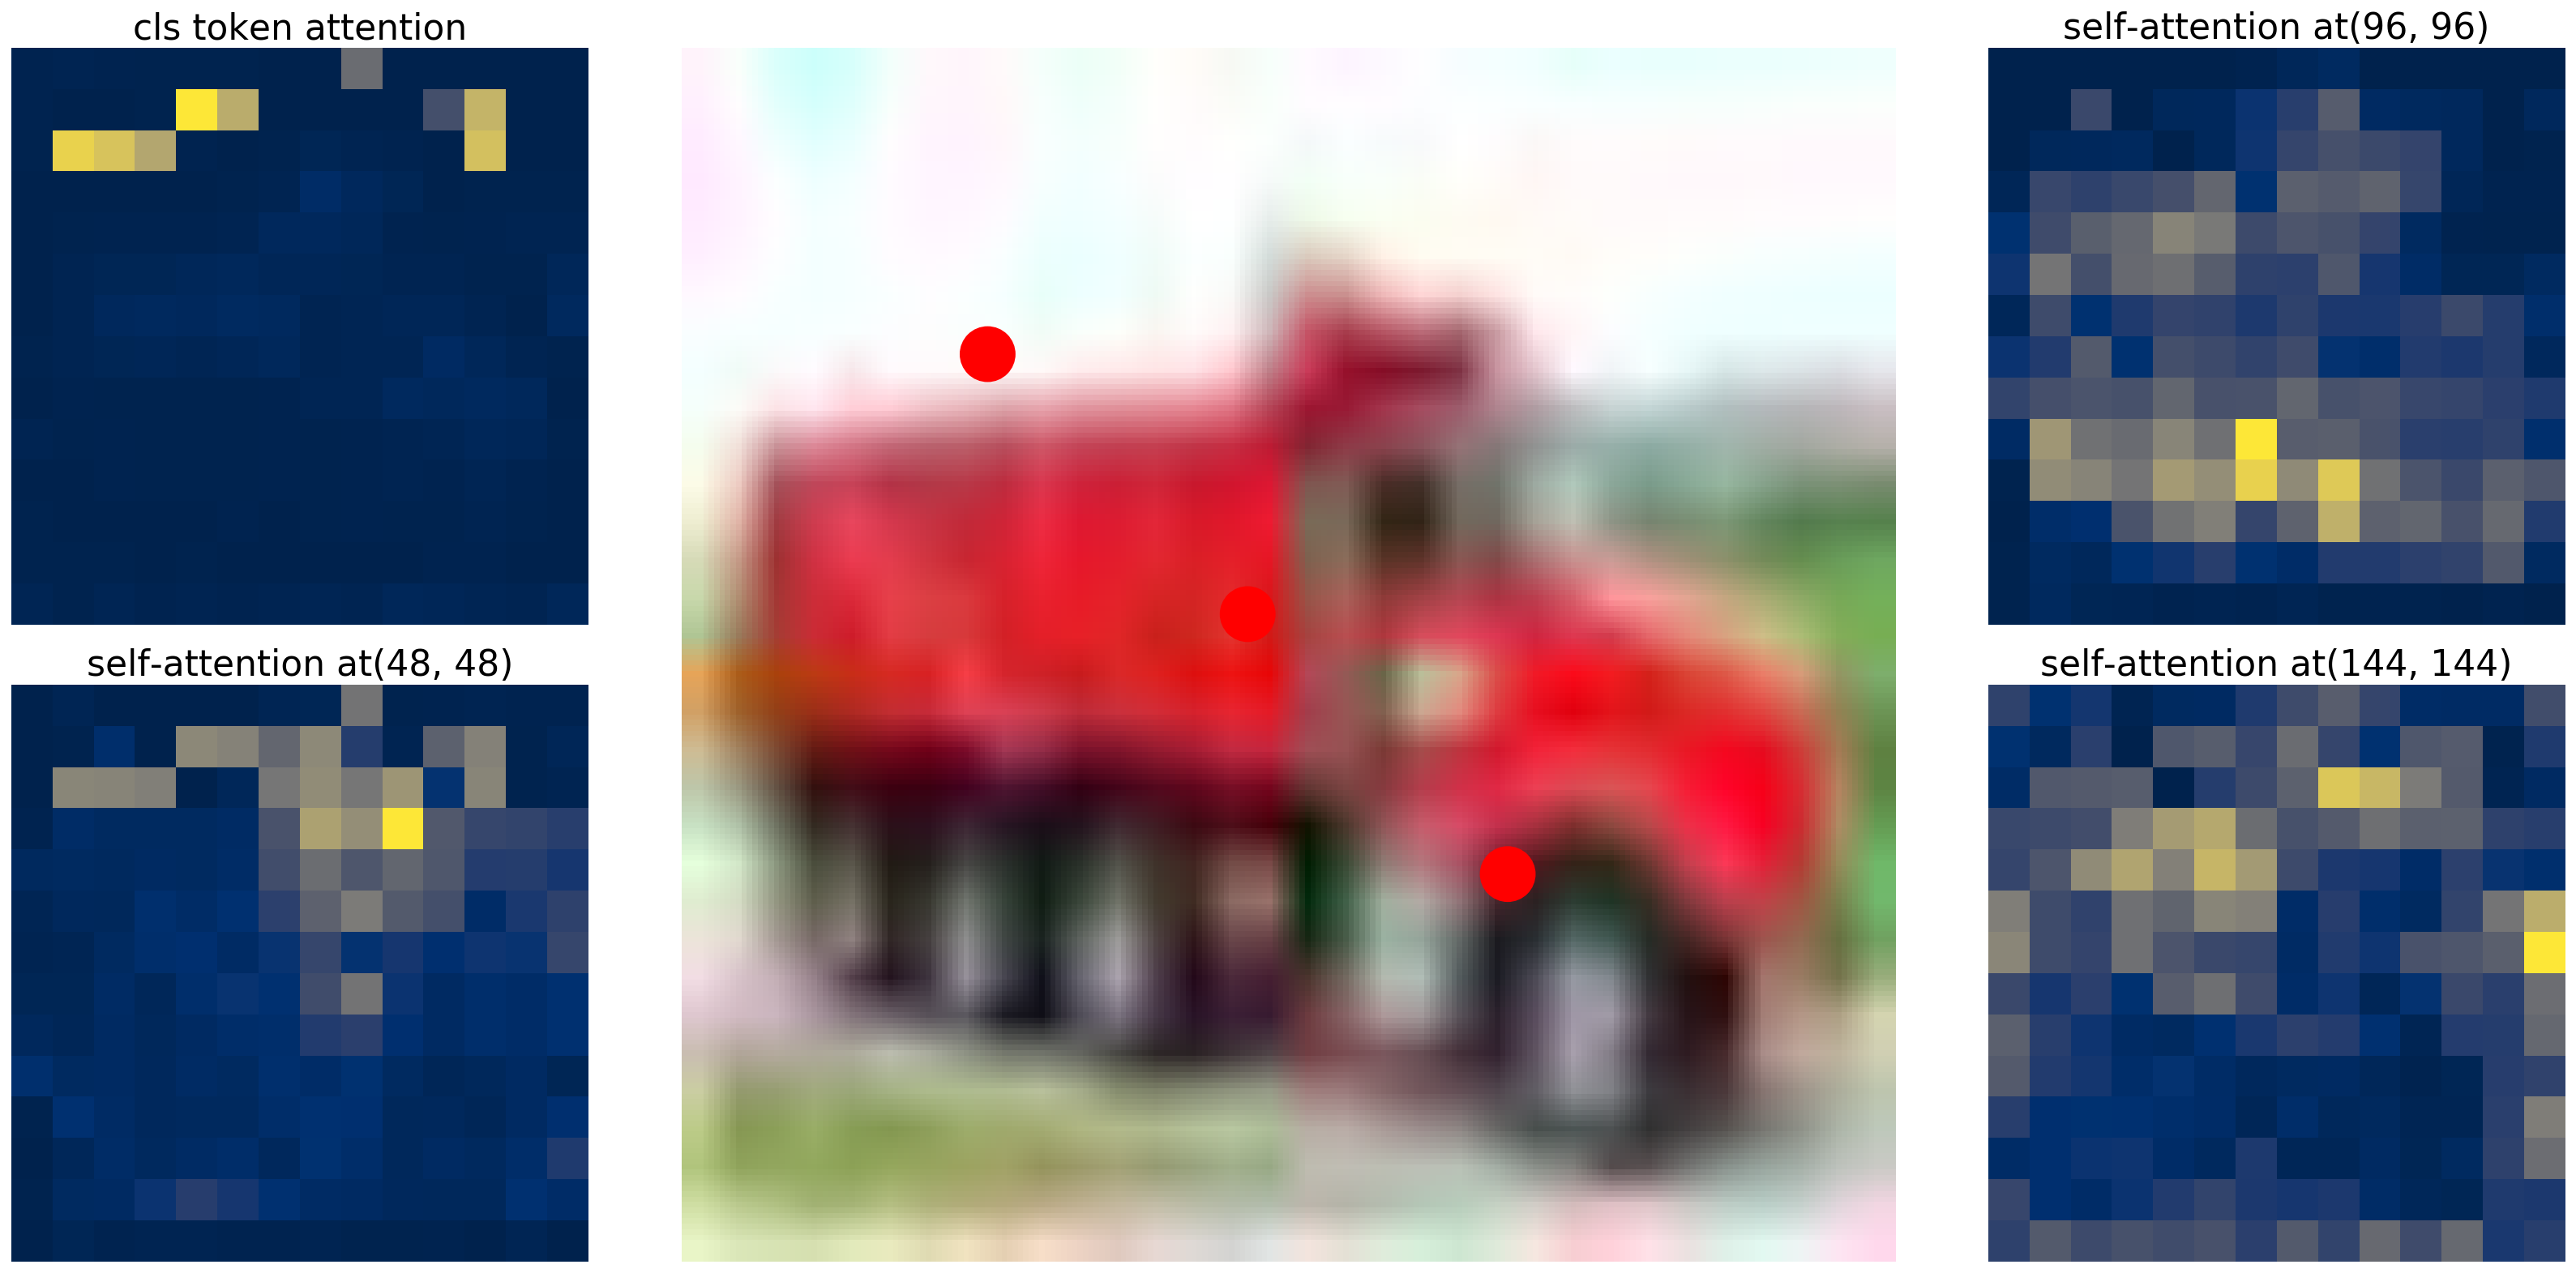

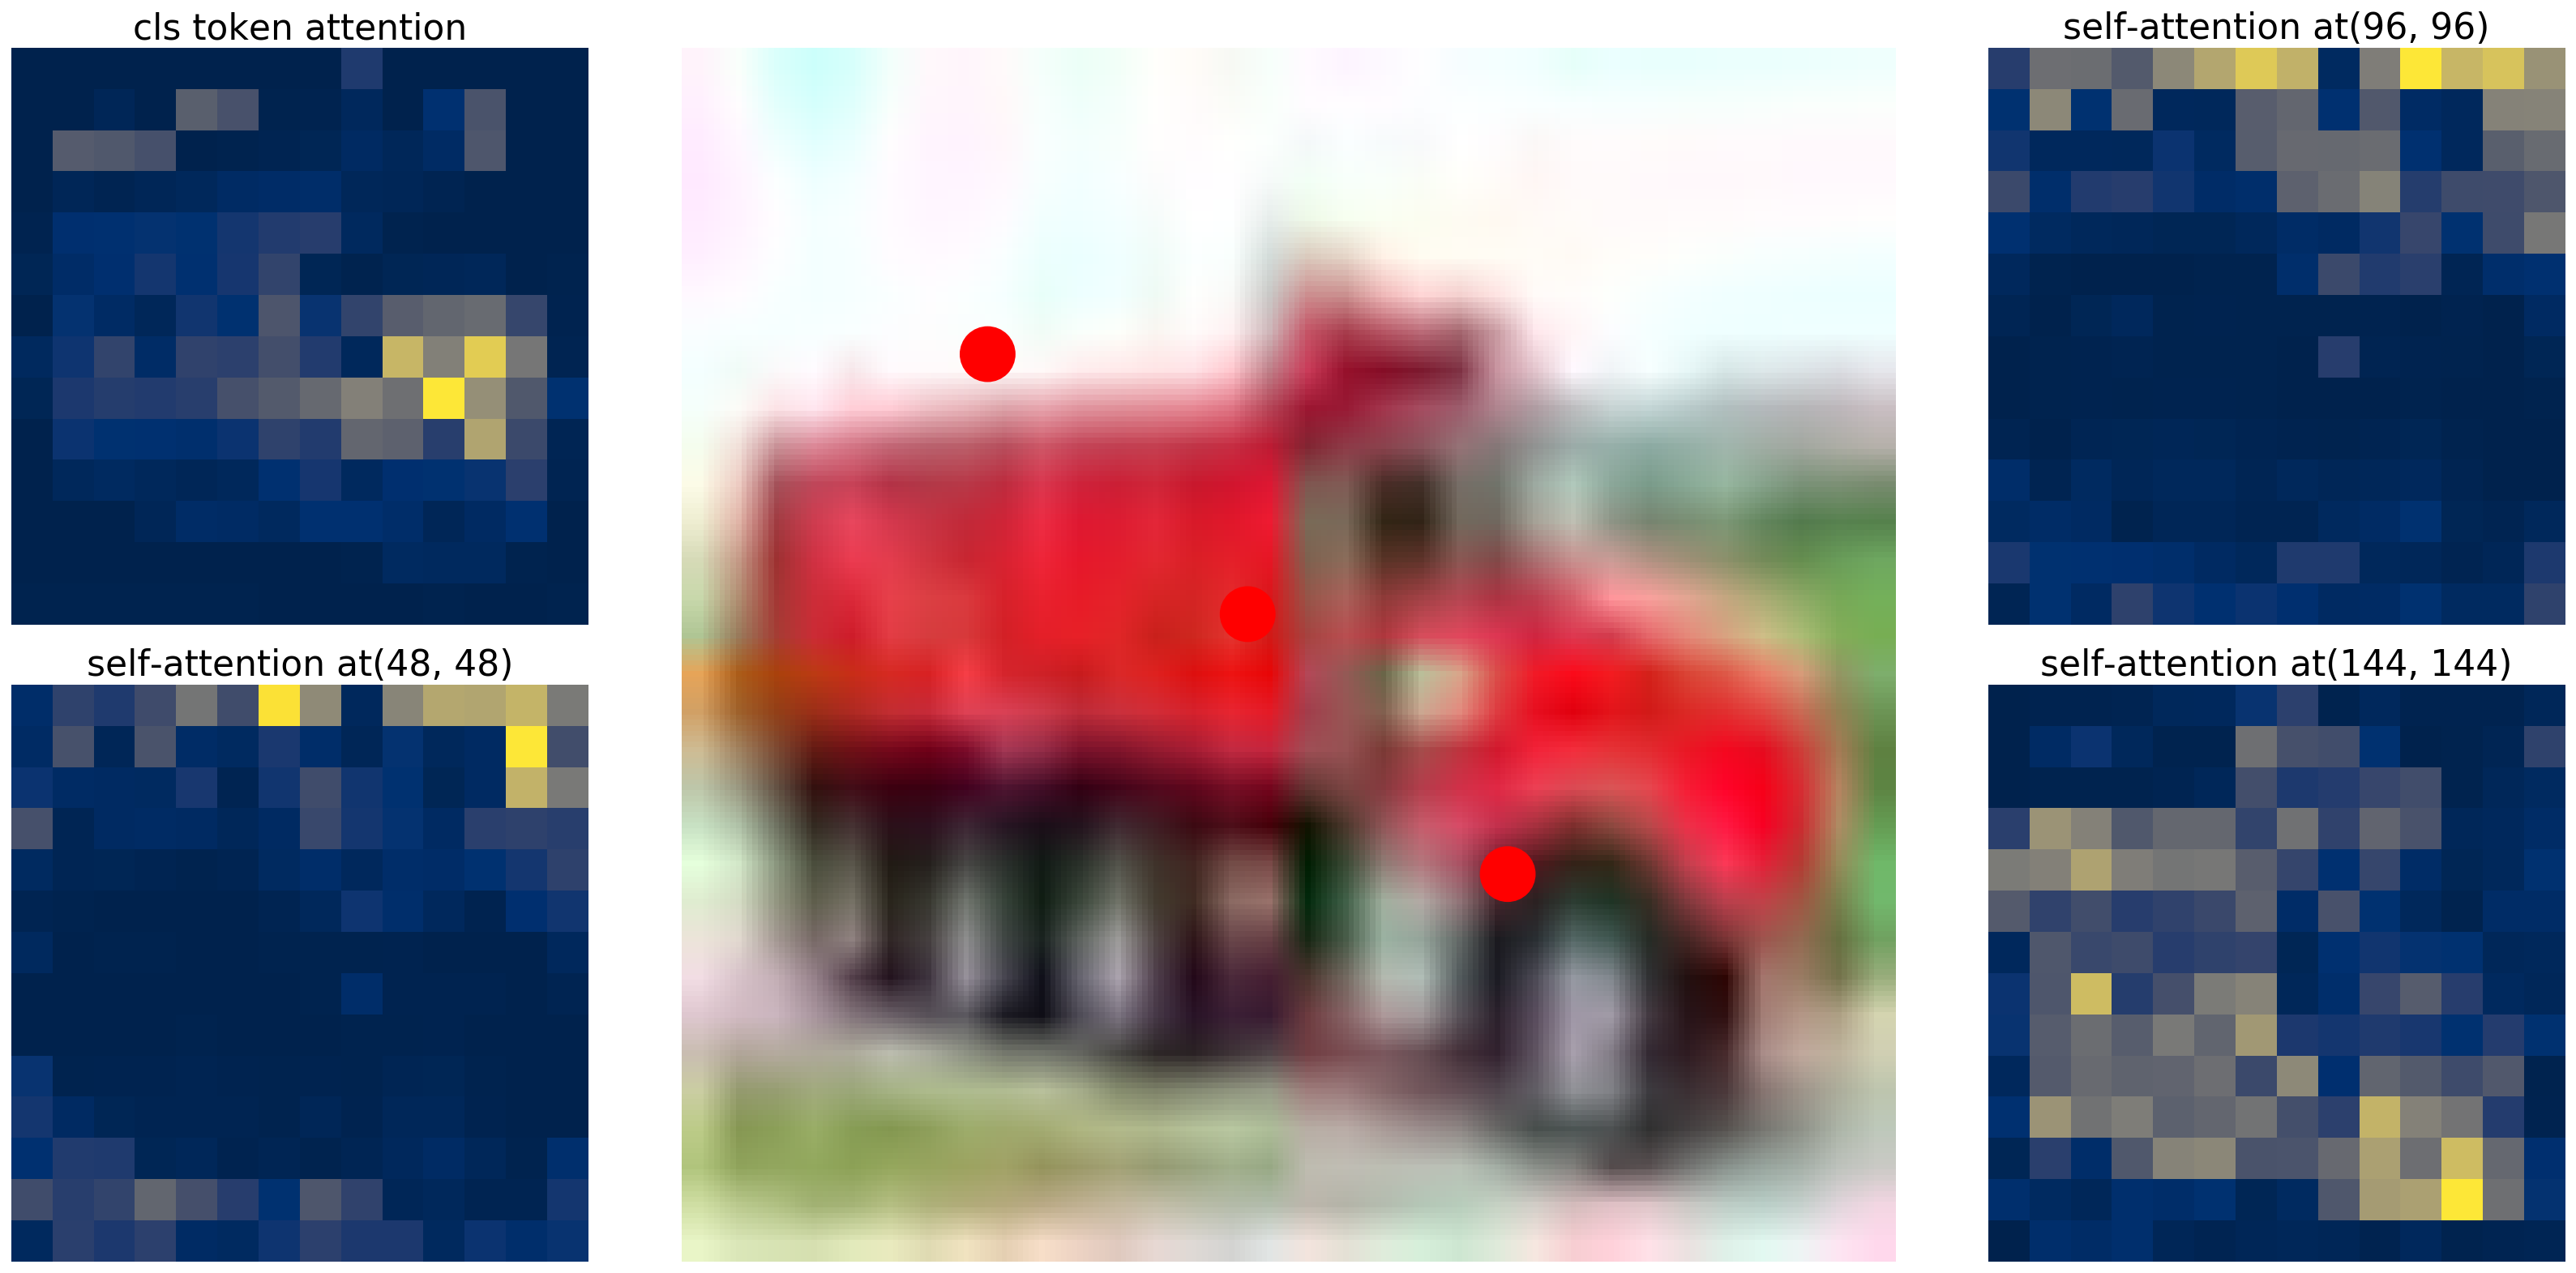

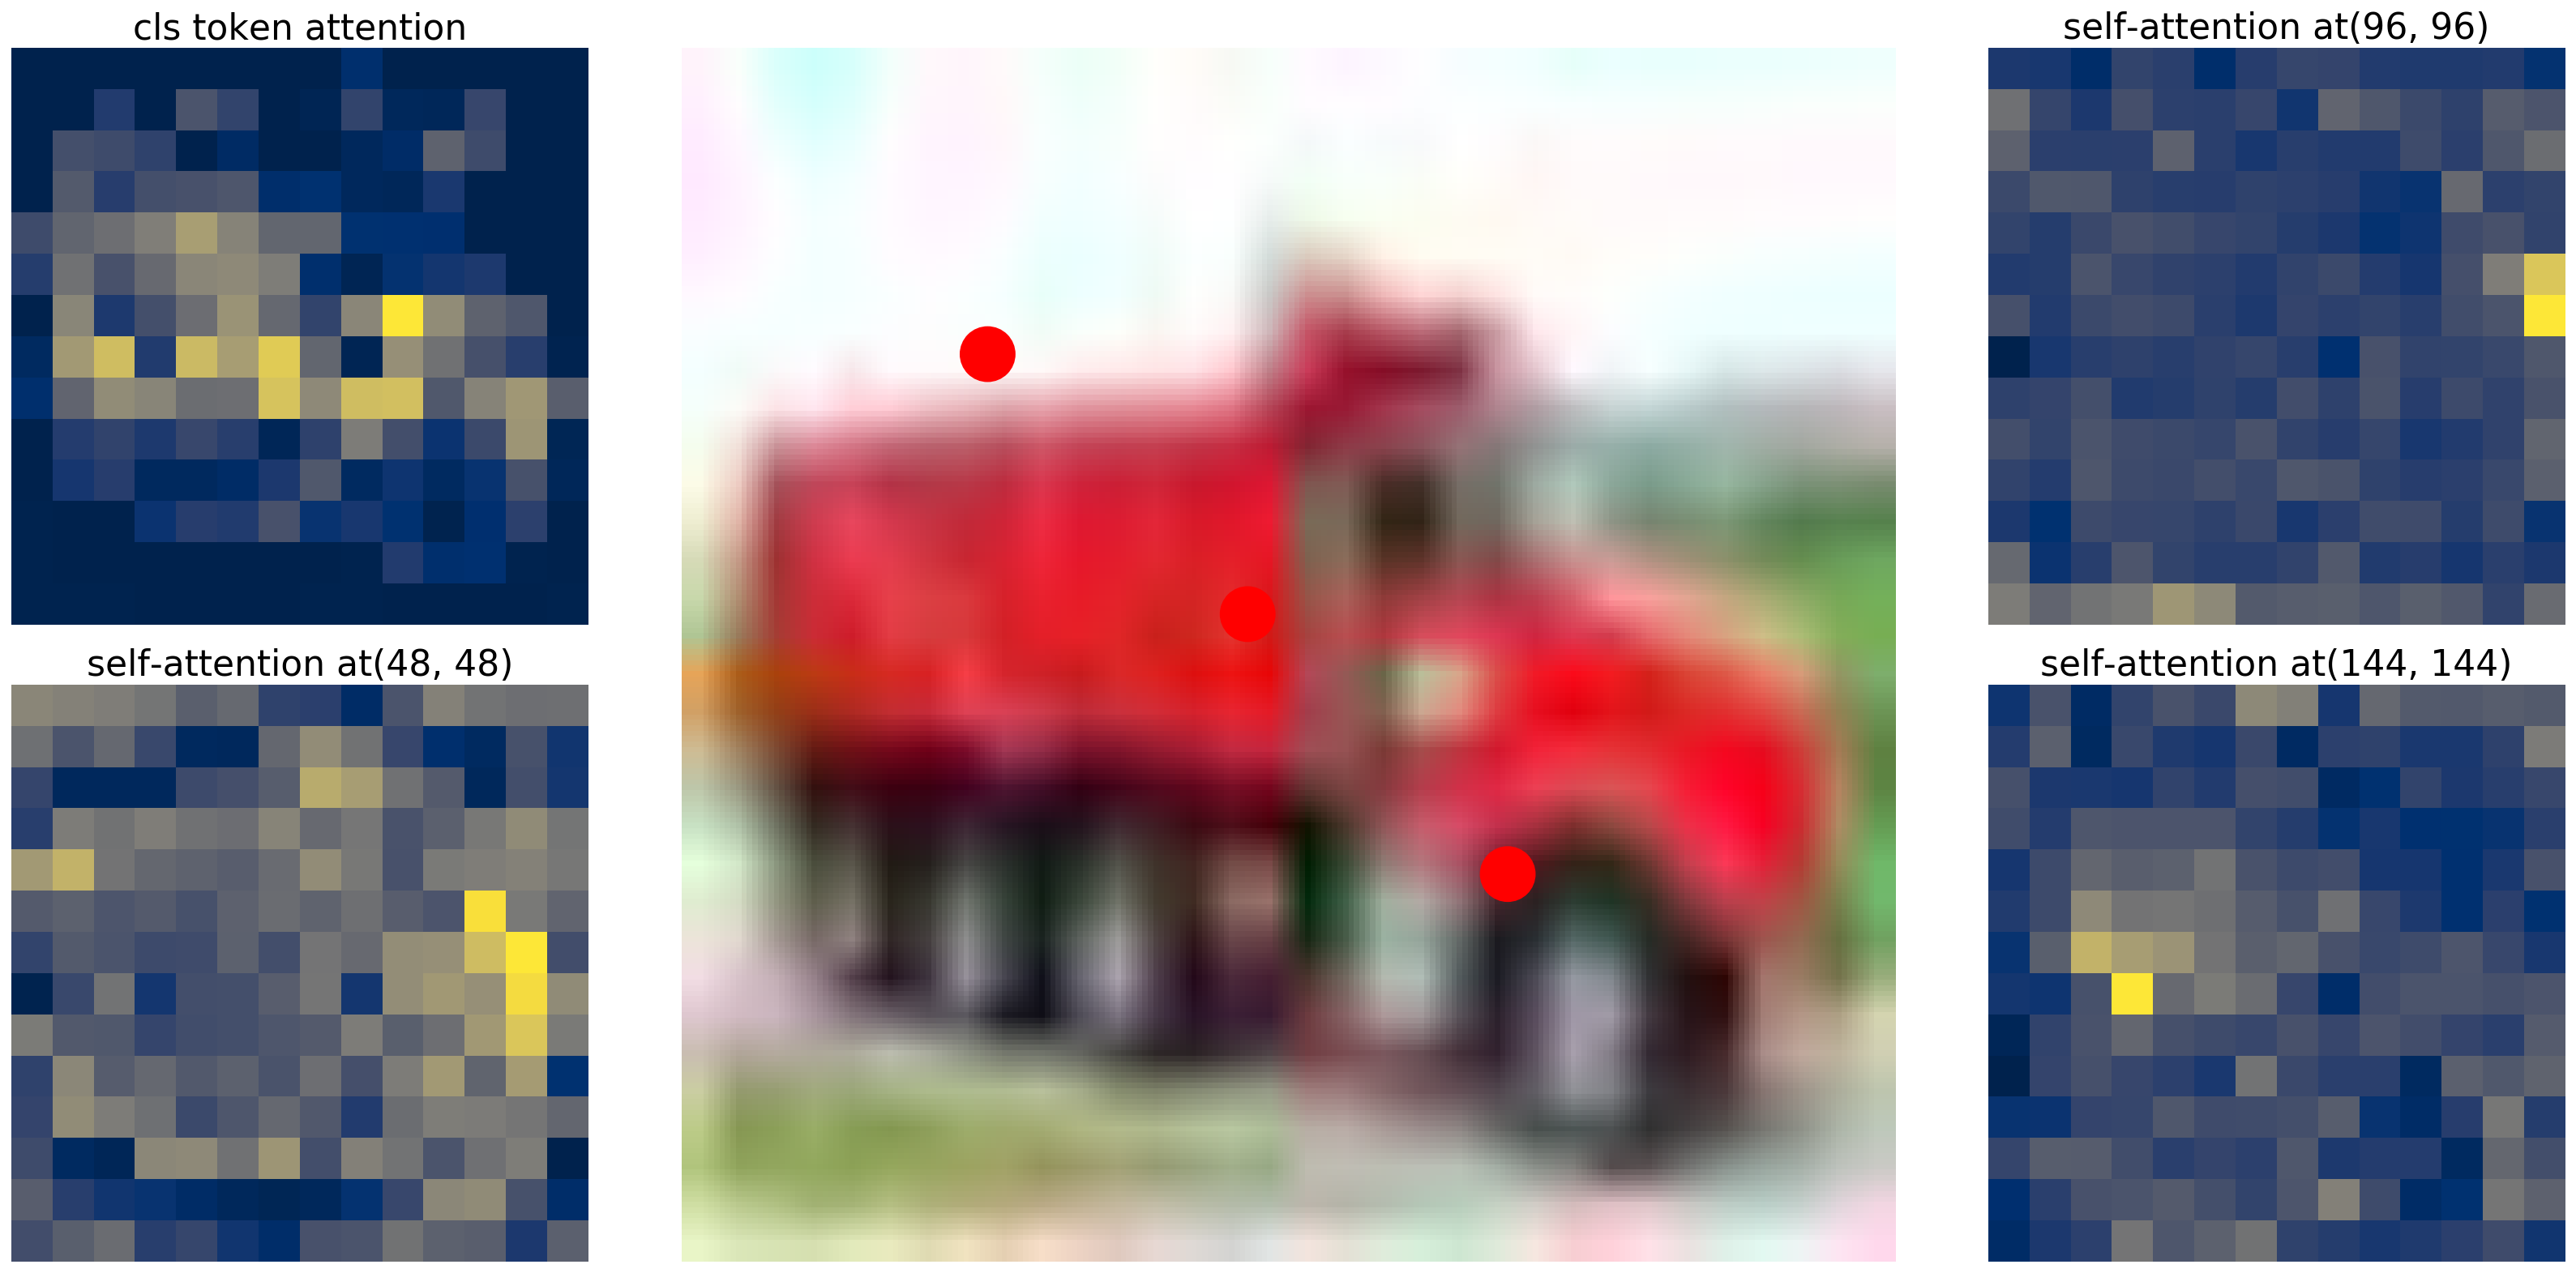

In [146]:
for i in range(12):
    if i in (4,8,9,10,11): # show only 4th 8th and 11th or last layer
        # get the HxW shape of the feature maps of the ViT
        shape = f_map
        # and reshape the self-attention to a more interpretable shape
        cls_attn = cls_token_attn[i][head_to_show].reshape(shape)
        #print(np.around(cls_attn,2))
        #print('Shape of cls attn : ',cls_attn.shape)
        sattn = enc_attn_weights[i][head_to_show].reshape(shape + shape)
        #print("Reshaped self-attention:", sattn.shape)
        #print('Showing layer {} and and head {}'.format(i,head_to_show))

        fact = 16 # as image size was 160 and number of attn block 160/16=10

        # let's select 3 reference points AND CLASIFICATION TOKEN for visualization in transformed image space
        idxs = [(0,0),(48, 48), (96, 96), (144, 144),]

        # here we create the canvas
        fig = plt.figure(constrained_layout=True, figsize=(25 * 0.9, 12 * 0.9))
        # and we add one plot per reference point
        gs = fig.add_gridspec(2, 4)
        axs = [
            fig.add_subplot(gs[0, 0]),
            fig.add_subplot(gs[1, 0]),
            fig.add_subplot(gs[0, -1]),
            fig.add_subplot(gs[1, -1]),
        ]

        # for each one of the reference points, let's plot the self-attention
        # for that point
        for idx_o, ax in zip(idxs, axs):
            if idx_o==(0,0):
                idx = (idx_o[0] // fact, idx_o[1] // fact)
                ax.imshow(cls_attn, cmap='cividis', interpolation='nearest')
                ax.axis('off')
                #ax.set_title(f'cls attn at layer: {i}')
                ax.set_title('cls token attention',fontsize=22)
            else:
                idx = (idx_o[0] // fact, idx_o[1] // fact)
                ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
                ax.axis('off')
                #ax.set_title(f'self-attn{idx_o} at layer: {i}')
                ax.set_title(f'self-attention at{idx_o}',fontsize=22)

        # and now let's add the central image, with the reference points as red circles
        fcenter_ax = fig.add_subplot(gs[:, 1:-1])
        fcenter_ax.imshow(resize_transform(im))#cls_attn
        for (y, x) in idxs:
            if not (x==0 and y==0):
                x = ((x // fact) + 0.5) * fact
                y = ((y // fact) + 0.5) * fact
                fcenter_ax.add_patch(plt.Circle((x, y), fact // 3, color='r'))
                fcenter_ax.axis('off')
        #plt.savefig(f'figures/vit_attention/{img_name}_{i}.png')

That's pretty nice! This visualization gives the intuition that the encoder might be already performing some sort of object separation thanks to the self-attention mechanism.

## Interactive visualization of self-attention
In the following cell, we wrap the above snippets into a widget so that it makes it easier to insert your own image or define the reference points for easier visualization.

That's it! Now try it on your own image and see what the self-attention of the Transformer Encoder learned by itself!

# Conclusion

In this notebook, we showed:
- how to use torchhub to compute predictions on your own image,
- how to visualize the decoder inter-attention for each prediction,
- how to visualize the encoder self-attention for a given reference point.